In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder


In [3]:
df = pd.read_csv('/content/drive/MyDrive/game_preference.csv')

In [4]:
columns_to_drop = ['developer', 'publisher', 'score_rank', 'positive', 'negative', 'owners', 'currency', 'positive_ratio']
df= df.drop(columns=columns_to_drop)

# Display the remaining columns to verify
df.head()


,appid,name,average_forever,average_2weeks,median_forever,median_2weeks,ccu,genre,final,categories 1,categories 2,ratings,owners_average,MutualPlayerCount
0,10,Counter-Strike,8894,525,157,757,12121,Action,9.99,Multi-player,PvP,0.952840,15000000,831
1,30,Day of Defeat,158,188,15,188,110,Action,4.99,Multi-player,Valve Anti-Cheat enabled,0.801467,7500000,103
2,70,Half-Life,574,50,134,75,1135,Action,9.99,Single-player,Multi-player,0.930085,15000000,525
3,220,Half-Life 2,838,35,350,59,1172,Action,9.99,Single-player,Steam Achievements,0.949639,7500000,1068
4,240,Counter-Strike: Source,9450,489,394,848,9549,Action,9.99,Multi-player,Cross-Platform Multiplayer,0.935661,15000000,1039


In [5]:
df.rename(columns = {'final' : 'price'}, inplace = True)

In [6]:
# Ensure 'genre' is either list or string
print("Before converting lists to strings in 'genre':")
print(df['genre'].head())

if any(df['genre'].apply(lambda x: isinstance(x, list))):
    df['genre'] = df['genre'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

print("After converting lists to strings in 'genre':")
print(df['genre'].head())

# Clean the 'categories 2' column by stripping leading/trailing spaces
df['categories 2'] = df['categories 2'].str.strip()

print("After stripping spaces in 'categories 2':")
print(df['categories 2'].head())

# Filter 'categories 2' to include only 'Single-player' and 'Multi-player'
df['categories 2'] = df['categories 2'].apply(lambda x: x if x in ['Single-player', 'Multi-player'] else None)

print("After filtering 'categories 2':")
print(df['categories 2'].head())

# OneHotEncoder initialization with handle_unknown set to 'ignore'
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encoding 'categories 1'
categories_1_valid = df[['categories 1']].dropna()
categories_encoded_1 = one_hot_encoder.fit_transform(categories_1_valid)
cat1_feature_names = ['cat_1_' + feature.split('_')[-1] for feature in one_hot_encoder.get_feature_names_out()]
categories_encoded_df_1 = pd.DataFrame(categories_encoded_1, columns=cat1_feature_names, index=categories_1_valid.index)

print("Encoded 'categories 1':")
print(categories_encoded_df_1.head())

# Encoding 'categories 2'
categories_2_valid = df[['categories 2']].fillna('Ignore')
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories=[['Single-player', 'Multi-player']])
categories_encoded_2 = one_hot_encoder.fit_transform(categories_2_valid)
cat2_feature_names = ['cat_2_' + feature.split('_')[-1] for feature in one_hot_encoder.categories_[0]]
categories_encoded_df_2 = pd.DataFrame(categories_encoded_2, columns=cat2_feature_names, index=categories_2_valid.index)

print("Encoded 'categories 2':")
print(categories_encoded_df_2.head())

# Joining the new DataFrames with the original data
data_encoded = df.join(categories_encoded_df_1).join(categories_encoded_df_2)

print("Data after joining encoded categories:")
print(data_encoded[['cat_1_Single-player', 'cat_1_Multi-player', 'cat_2_Single-player', 'cat_2_Multi-player']].head())

# Function to split the genres into lists of individual genres
def split_genres(genre):
    if pd.isna(genre):
        return []
    return [g.strip() for g in genre.split(',')]

# Apply the function to the genre column
data_encoded['genre'] = data_encoded['genre'].apply(split_genres)

print("After splitting 'genre' into lists:")
print(data_encoded['genre'].head())

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the genre data
genres_encoded = mlb.fit_transform(data_encoded['genre'])

# Create a DataFrame from the encoded genres
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

print("Encoded 'genre':")
print(genres_encoded_df.head())

# Merge the encoded DataFrame with the original data
data_encoded = data_encoded.join(genres_encoded_df)

# Display the first few rows to check the result
print("Final encoded DataFrame:")
print(data_encoded.head())

Before converting lists to strings in 'genre':
0    Action
1    Action
2    Action
3    Action
4    Action
Name: genre, dtype: object
After converting lists to strings in 'genre':
0    Action
1    Action
2    Action
3    Action
4    Action
Name: genre, dtype: object
After stripping spaces in 'categories 2':
0                           PvP
1      Valve Anti-Cheat enabled
2                  Multi-player
3            Steam Achievements
4    Cross-Platform Multiplayer
Name: categories 2, dtype: object
After filtering 'categories 2':
0            None
1            None
2    Multi-player
3            None
4            None
Name: categories 2, dtype: object
Encoded 'categories 1':
   cat_1_Multi-player  cat_1_Single-player
0                 1.0                  0.0
1                 1.0                  0.0
2                 0.0                  1.0
3                 0.0                  1.0
4                 1.0                  0.0
Encoded 'categories 2':
   cat_2_Single-player  cat_2_Multi

In [7]:
# now removing unnecessary columns
columns_to_drop = ['categories 2','categories 1', 'genre']
data_encoded= data_encoded.drop(columns=columns_to_drop)

# Display the remaining columns to verify
data_encoded.head()


,appid,name,average_forever,average_2weeks,median_forever,median_2weeks,ccu,price,ratings,owners_average,...,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Web Publishing
0,10,Counter-Strike,8894,525,157,757,12121,9.99,0.952840,15000000,...,0,0,0,0,0,0,0,0,0,0
1,30,Day of Defeat,158,188,15,188,110,4.99,0.801467,7500000,...,0,0,0,0,0,0,0,0,0,0
2,70,Half-Life,574,50,134,75,1135,9.99,0.930085,15000000,...,0,0,0,0,0,0,0,0,0,0
3,220,Half-Life 2,838,35,350,59,1172,9.99,0.949639,7500000,...,0,0,0,0,0,0,0,0,0,0
4,240,Counter-Strike: Source,9450,489,394,848,9549,9.99,0.935661,15000000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Print null values count before dropping
print("Before dropping nulls:")
print(data_encoded.isnull().sum())



Before dropping nulls:
appid                    0
name                     2
average_forever          0
average_2weeks           0
median_forever           0
median_2weeks            0
ccu                      0
price                    0
ratings                  0
owners_average           0
MutualPlayerCount        0
cat_1_Multi-player       0
cat_1_Single-player      0
cat_2_Single-player      0
cat_2_Multi-player       0
Action                   0
Adventure                0
Animation & Modeling     0
Casual                   0
Design & Illustration    0
Early Access             0
Education                0
Free to Play             0
Game Development         0
Gore                     0
Indie                    0
Massively Multiplayer    0
Movie                    0
Nudity                   0
RPG                      0
Racing                   0
Sexual Content           0
Simulation               0
Sports                   0
Strategy                 0
Utilities                0
Viole

In [9]:

# Drop rows with any null values directly in the original DataFrame
df.dropna(inplace=True)

# Print null values count after dropping to verify
print("After dropping nulls:")
print(df.isnull().sum())

After dropping nulls:
appid                0
name                 0
average_forever      0
average_2weeks       0
median_forever       0
median_2weeks        0
ccu                  0
genre                0
price                0
categories 1         0
categories 2         0
ratings              0
owners_average       0
MutualPlayerCount    0
dtype: int64


In [10]:
# Summing the columns for 'Single-player'
data_encoded['single player'] = data_encoded['cat_1_Single-player'] + data_encoded['cat_2_Single-player']
data_encoded['single player'] = data_encoded['single player'].clip(upper=1)  # Ensure the maximum value is 1

# Summing the columns for 'Multi-player'
data_encoded['multi player'] = data_encoded['cat_1_Multi-player'] + data_encoded['cat_2_Multi-player']
data_encoded['multi player'] = data_encoded['multi player'].clip(upper=1)  # Ensure the maximum value is 1

# Display the first few rows to check the new columns
print(data_encoded[['single player', 'multi player']].head())


   single player  multi player
0            0.0           1.0
1            0.0           1.0
2            1.0           1.0
3            1.0           0.0
4            0.0           1.0


In [11]:
# Create the 'both' column based on the condition
data_encoded['both'] = ((data_encoded['single player'] == 1) & (data_encoded['multi player'] == 1)).astype(int)

# Set 'single player' and 'multi player' to 0 where 'both' is 1
data_encoded.loc[data_encoded['both'] == 1, ['single player', 'multi player']] = 0

# Display the updated DataFrame
print(data_encoded)

      appid                                         name  average_forever  \
0        10                               Counter-Strike             8894   
1        30                                Day of Defeat              158   
2        70                                    Half-Life              574   
3       220                                  Half-Life 2              838   
4       240                       Counter-Strike: Source             9450   
..      ...                                          ...              ...   
831  812450                             The m0rg VS keys                0   
832  815830                                Space Escape!                0   
833  816710                                     Gray Cat               16   
834  817110                             Bitcoin VS Brain                0   
835  821720  20.000 Leagues Under The Sea - Captain Nemo                0   

     average_2weeks  median_forever  median_2weeks    ccu  price   ratings 

In [12]:
# now removing unnecessary columns
columns_to_drop = ['cat_1_Multi-player','cat_1_Single-player', 'cat_2_Single-player', 'cat_2_Multi-player']
data_encoded= data_encoded.drop(columns=columns_to_drop)

# Display the remaining columns to verify
data_encoded.columns


Index(['appid', 'name', 'average_forever', 'average_2weeks', 'median_forever',
       'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
       'MutualPlayerCount', 'Action', 'Adventure', 'Animation & Modeling',
       'Casual', 'Design & Illustration', 'Early Access', 'Education',
       'Free to Play', 'Game Development', 'Gore', 'Indie',
       'Massively Multiplayer', 'Movie', 'Nudity', 'RPG', 'Racing',
       'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Utilities',
       'Violent', 'Web Publishing', 'single player', 'multi player', 'both'],
      dtype='object')

### Raw data distribution

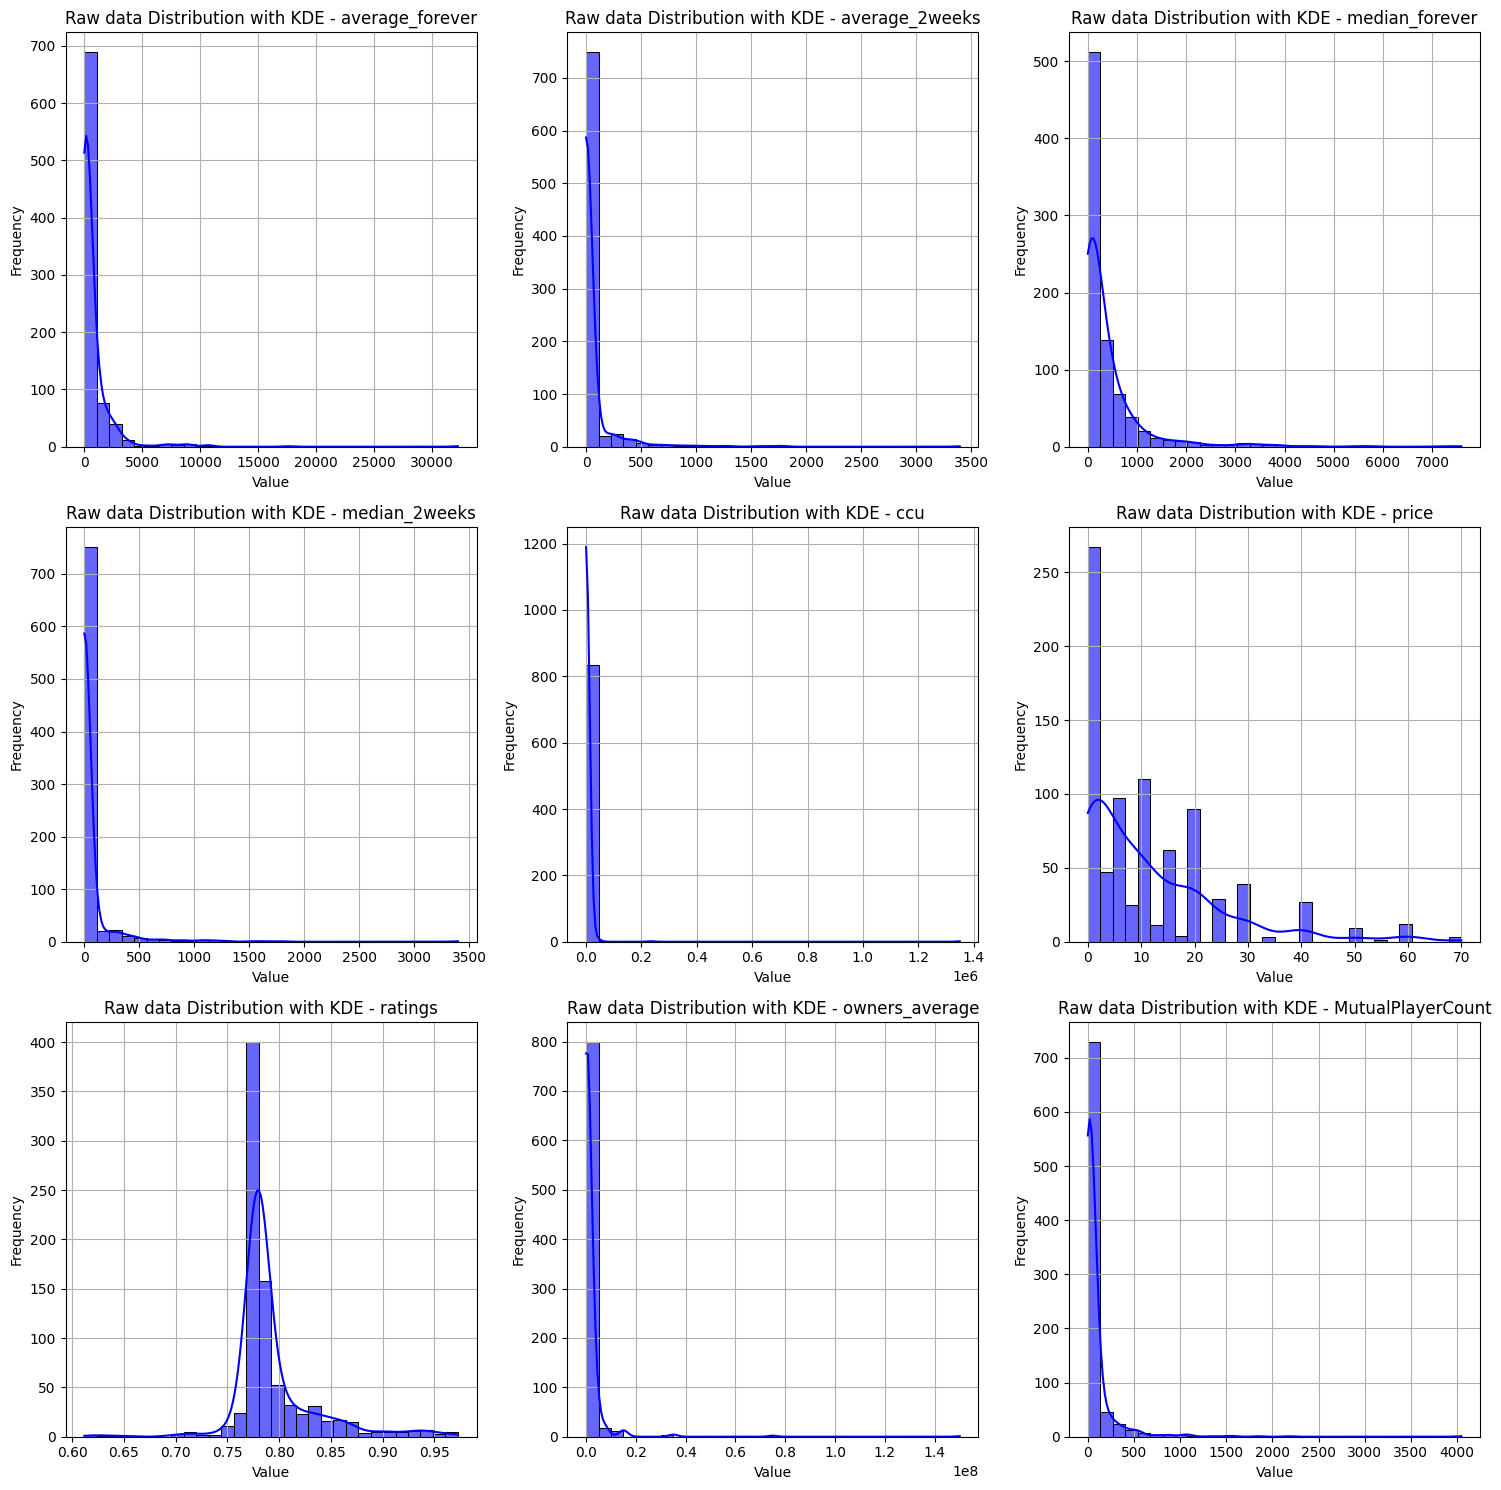

In [13]:
# Specify the columns you want to plot
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
                        'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                        'MutualPlayerCount']

# Determine the layout of the subplots
num_columns = 3  # Define the number of columns in your subplot grid
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the list of columns and create a plot for each one
for i, col in enumerate(columns_to_transform):
    sns.histplot(data_encoded[col], bins=30, kde=True, color='blue', alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Raw data Distribution with KDE - {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()


### log transformation

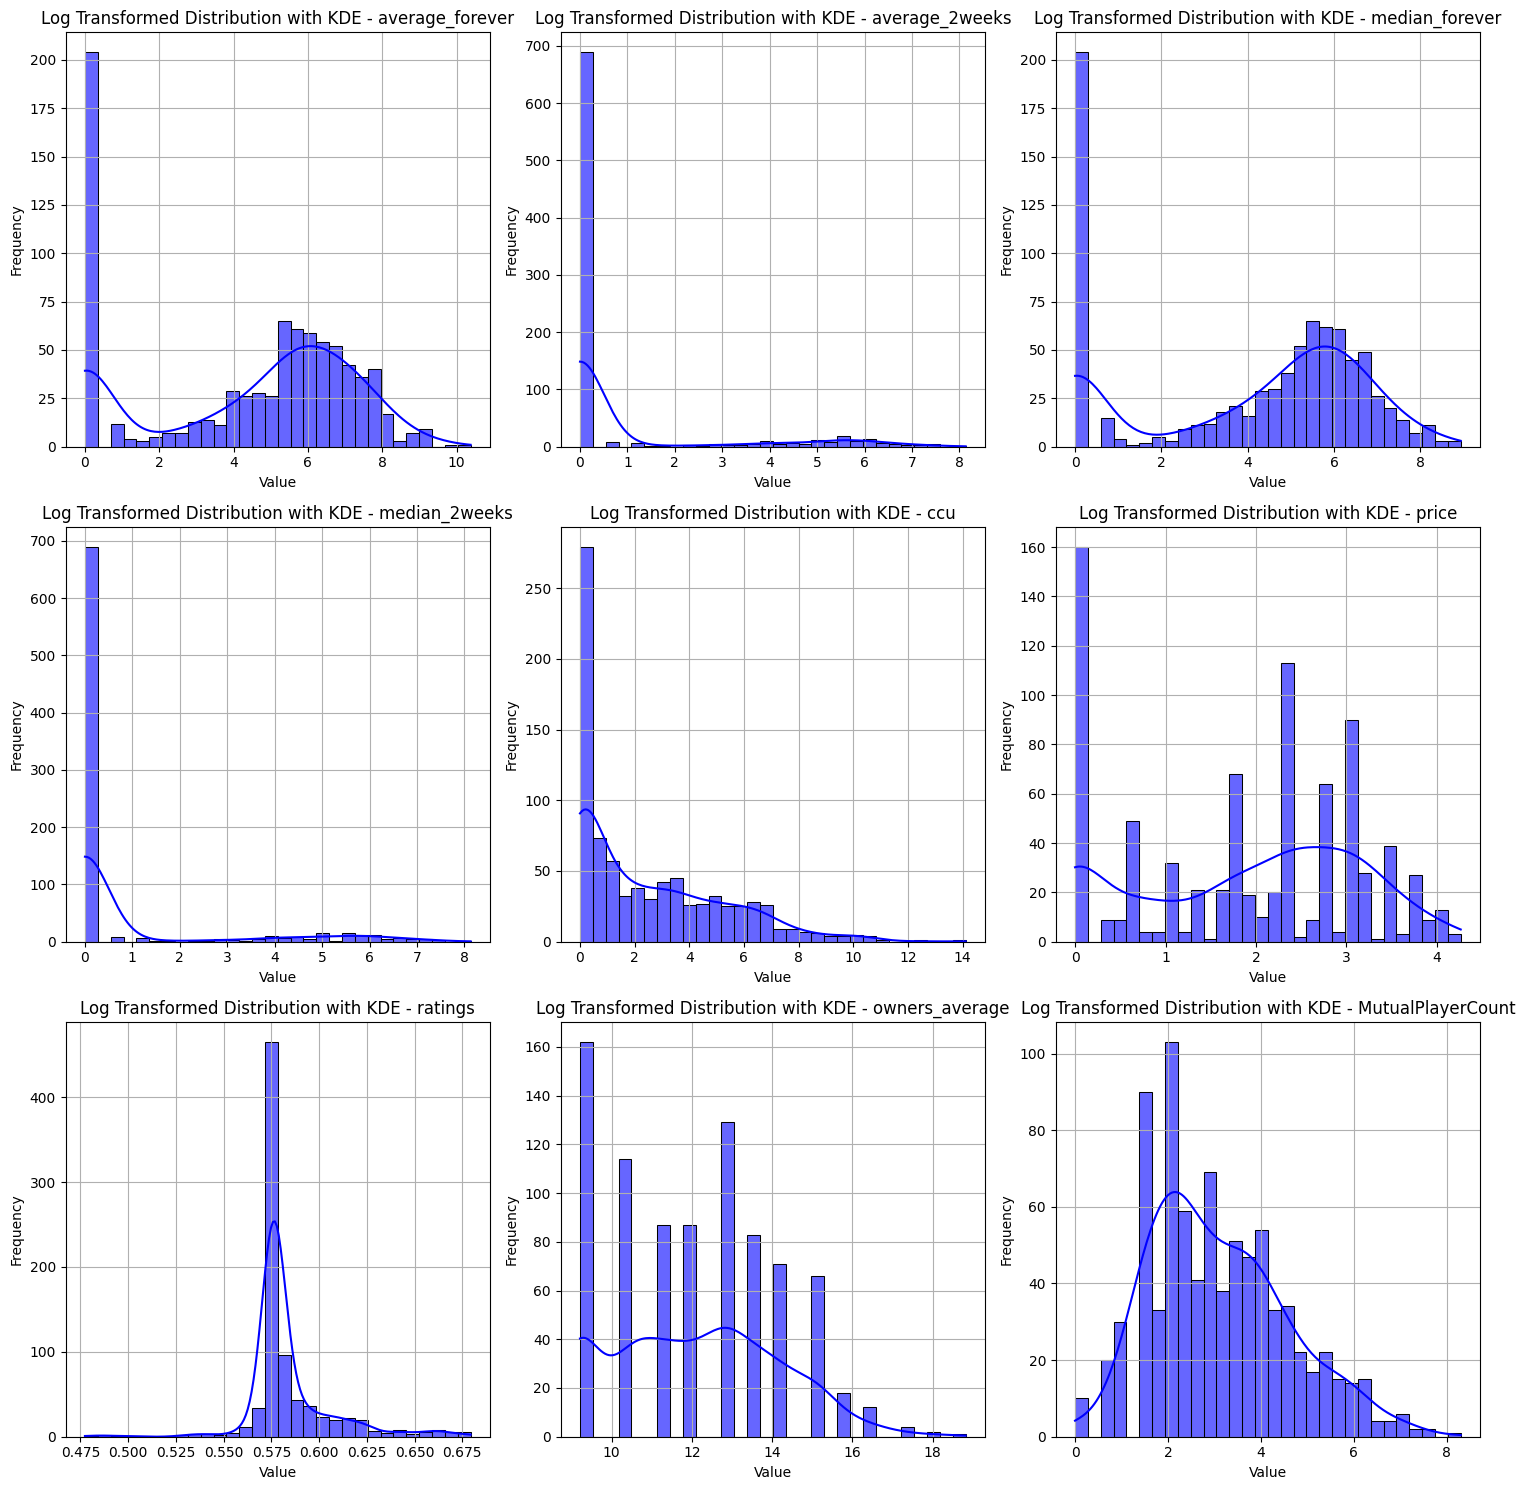

In [14]:
def apply_log_transformation(data, columns):
    transformed_data = data.copy()  # Create a copy of the data to keep the original dataframe untouched
    constant = 1  # You can adjust the constant as necessary
    for col in columns:
        transformed_data[col] = np.log(transformed_data[col] + constant)
    return transformed_data

# List of columns to transform
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
       'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
       'MutualPlayerCount']  # Add your specific column names here

# Apply the log transformation function to a copy for plotting
df_transformed = apply_log_transformation(data_encoded, columns_to_transform)

# Determine the layout of the subplots
num_columns = 3  # Define the number of columns in your subplot grid
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the list of columns and create a plot for each one
for i, col in enumerate(columns_to_transform):
    sns.histplot(df_transformed[col], bins=30, kde=True, color='blue', alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Log Transformed Distribution with KDE - {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()


### box cox transformation

Number of zero values after transforming average_forever: 204
Number of zero values after transforming average_2weeks: 689
Number of zero values after transforming median_forever: 204
Number of zero values after transforming median_2weeks: 689
Number of zero values after transforming ccu: 279
Number of zero values after transforming price: 160
Number of zero values after transforming ratings: 1
Number of zero values after transforming owners_average: 162
Number of zero values after transforming MutualPlayerCount: 10


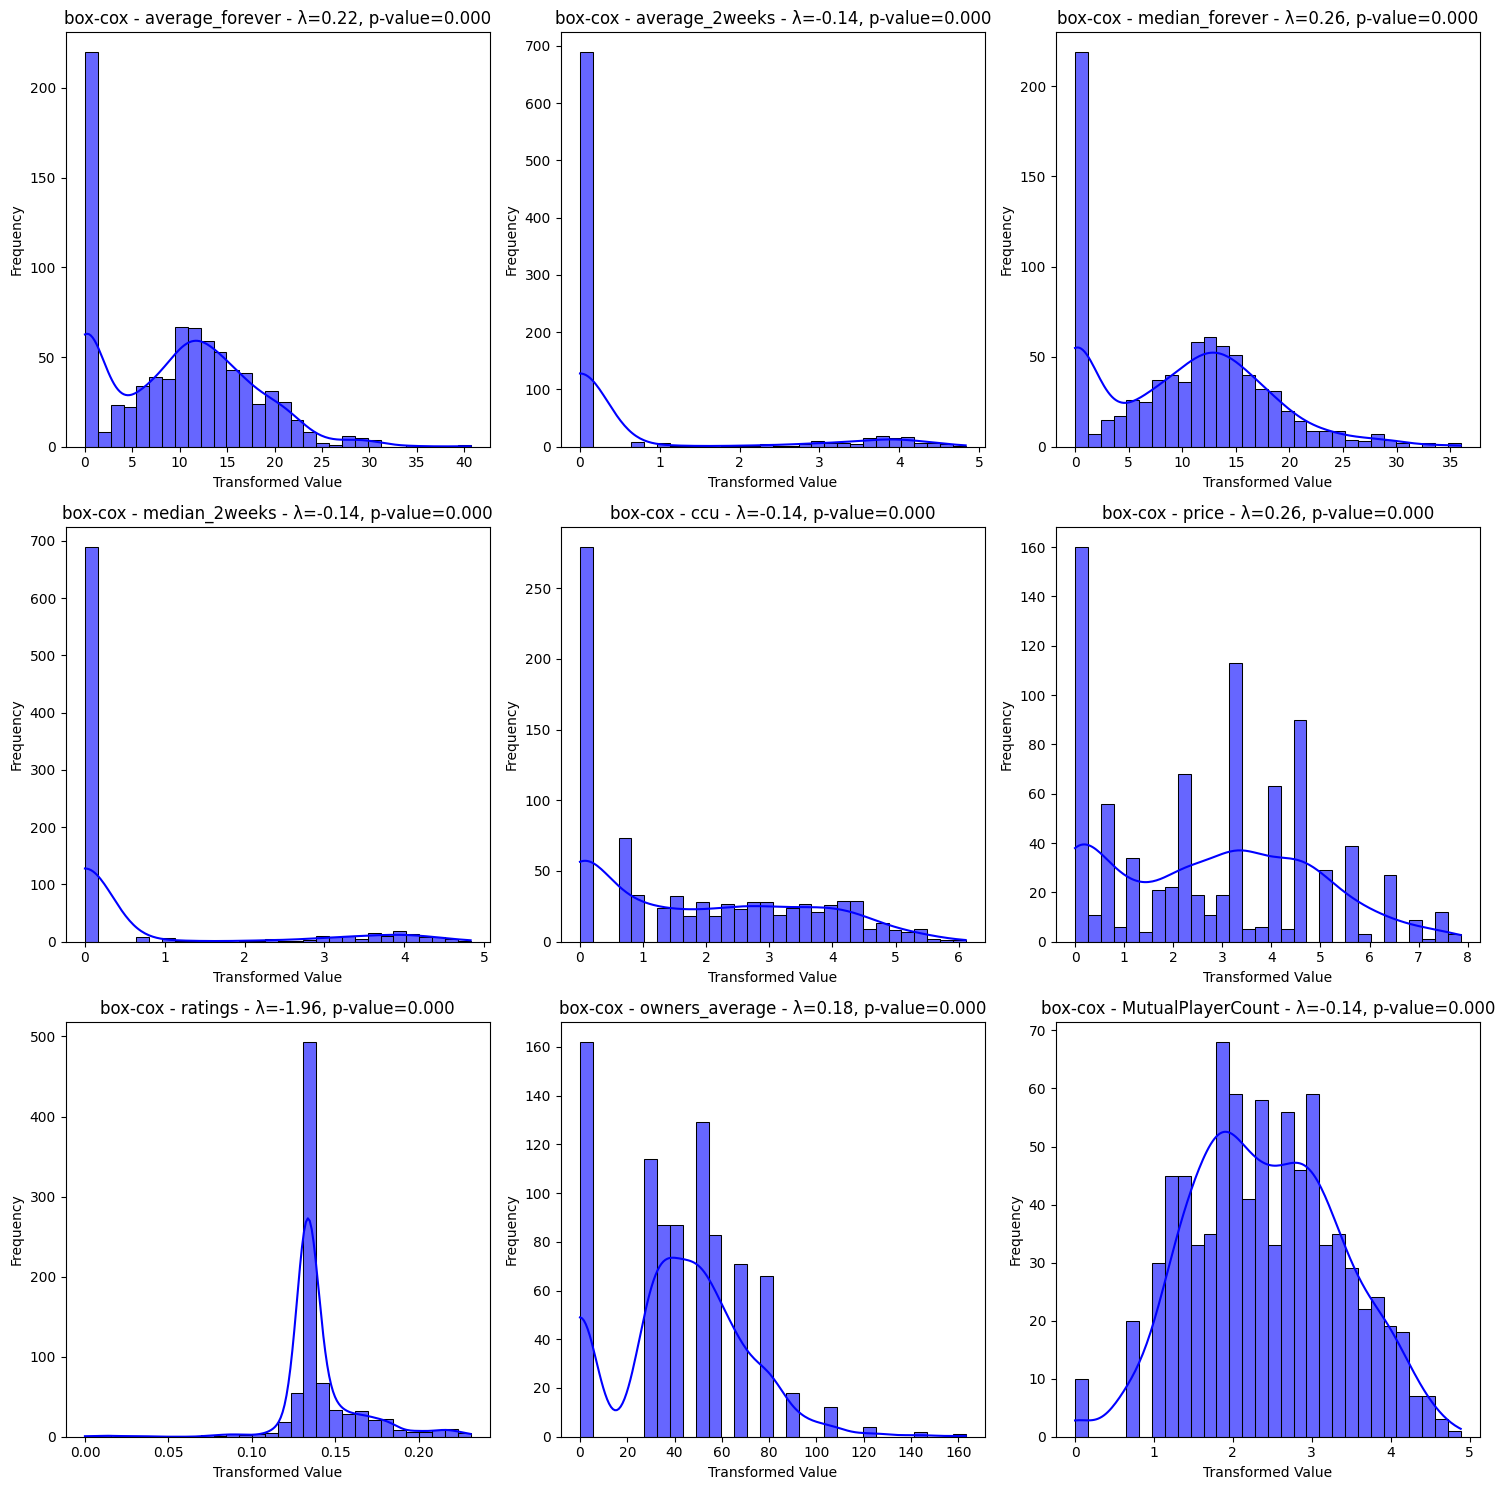

In [15]:
# Your specified columns to transform
columns_to_transform = ['average_forever', 'average_2weeks', 'median_forever',
                        'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                        'MutualPlayerCount']

# Prepare a subplot layout
num_columns = 3
num_rows = (len(columns_to_transform) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Explore a range of lambda values for each column
for index, col in enumerate(columns_to_transform):
    lambdas = np.linspace(-2, 2, num=100)  # Range of lambda values to explore
    best_pvalue = 0
    best_lambda = None
    best_transformed_data = None

    # Ensure all data are positive
    data_shifted = data_encoded[col] + 1 - np.min(data_encoded[col])

    # Try different lambda values
    for l in lambdas:
        transformed_data = stats.boxcox(data_shifted, lmbda=l)  # Note the change here, only one output
        shapiro_test = stats.shapiro(transformed_data)
        if shapiro_test.pvalue > best_pvalue:
            best_pvalue = shapiro_test.pvalue
            best_lambda = l
            best_transformed_data = transformed_data

    zeros_count = (transformed_data == 0).sum()
    print(f"Number of zero values after transforming {col}: {zeros_count}")


    # Plot the best transformed data
    sns.histplot(best_transformed_data, bins=30, kde=True, color='blue', alpha=0.6, ax=axes[index])
    axes[index].set_title(f'box-cox - {col} - λ={best_lambda:.2f}, p-value={best_pvalue:.3f}')
    axes[index].set_xlabel('Transformed Value')
    axes[index].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for i in range(index + 1, len(axes)):
    axes[i].axis('off')

# Show the plot
plt.show()

In [16]:
df_model = data_encoded.copy()

# Normalize column names in the DataFrame
df_model.columns = [col.lower().replace(' ', '_') for col in df_model.columns]

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(df_model, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print the sizes of each split
print(f"Train Data Size: {train_data.shape[0]} samples")
print(f"Validation Data Size: {validation_data.shape[0]} samples")
print(f"Test Data Size: {test_data.shape[0]} samples")




Train Data Size: 668 samples
Validation Data Size: 84 samples
Test Data Size: 84 samples


## quantile transformation

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (668). n_quantiles is set to n_samples.
  warnings.warn(


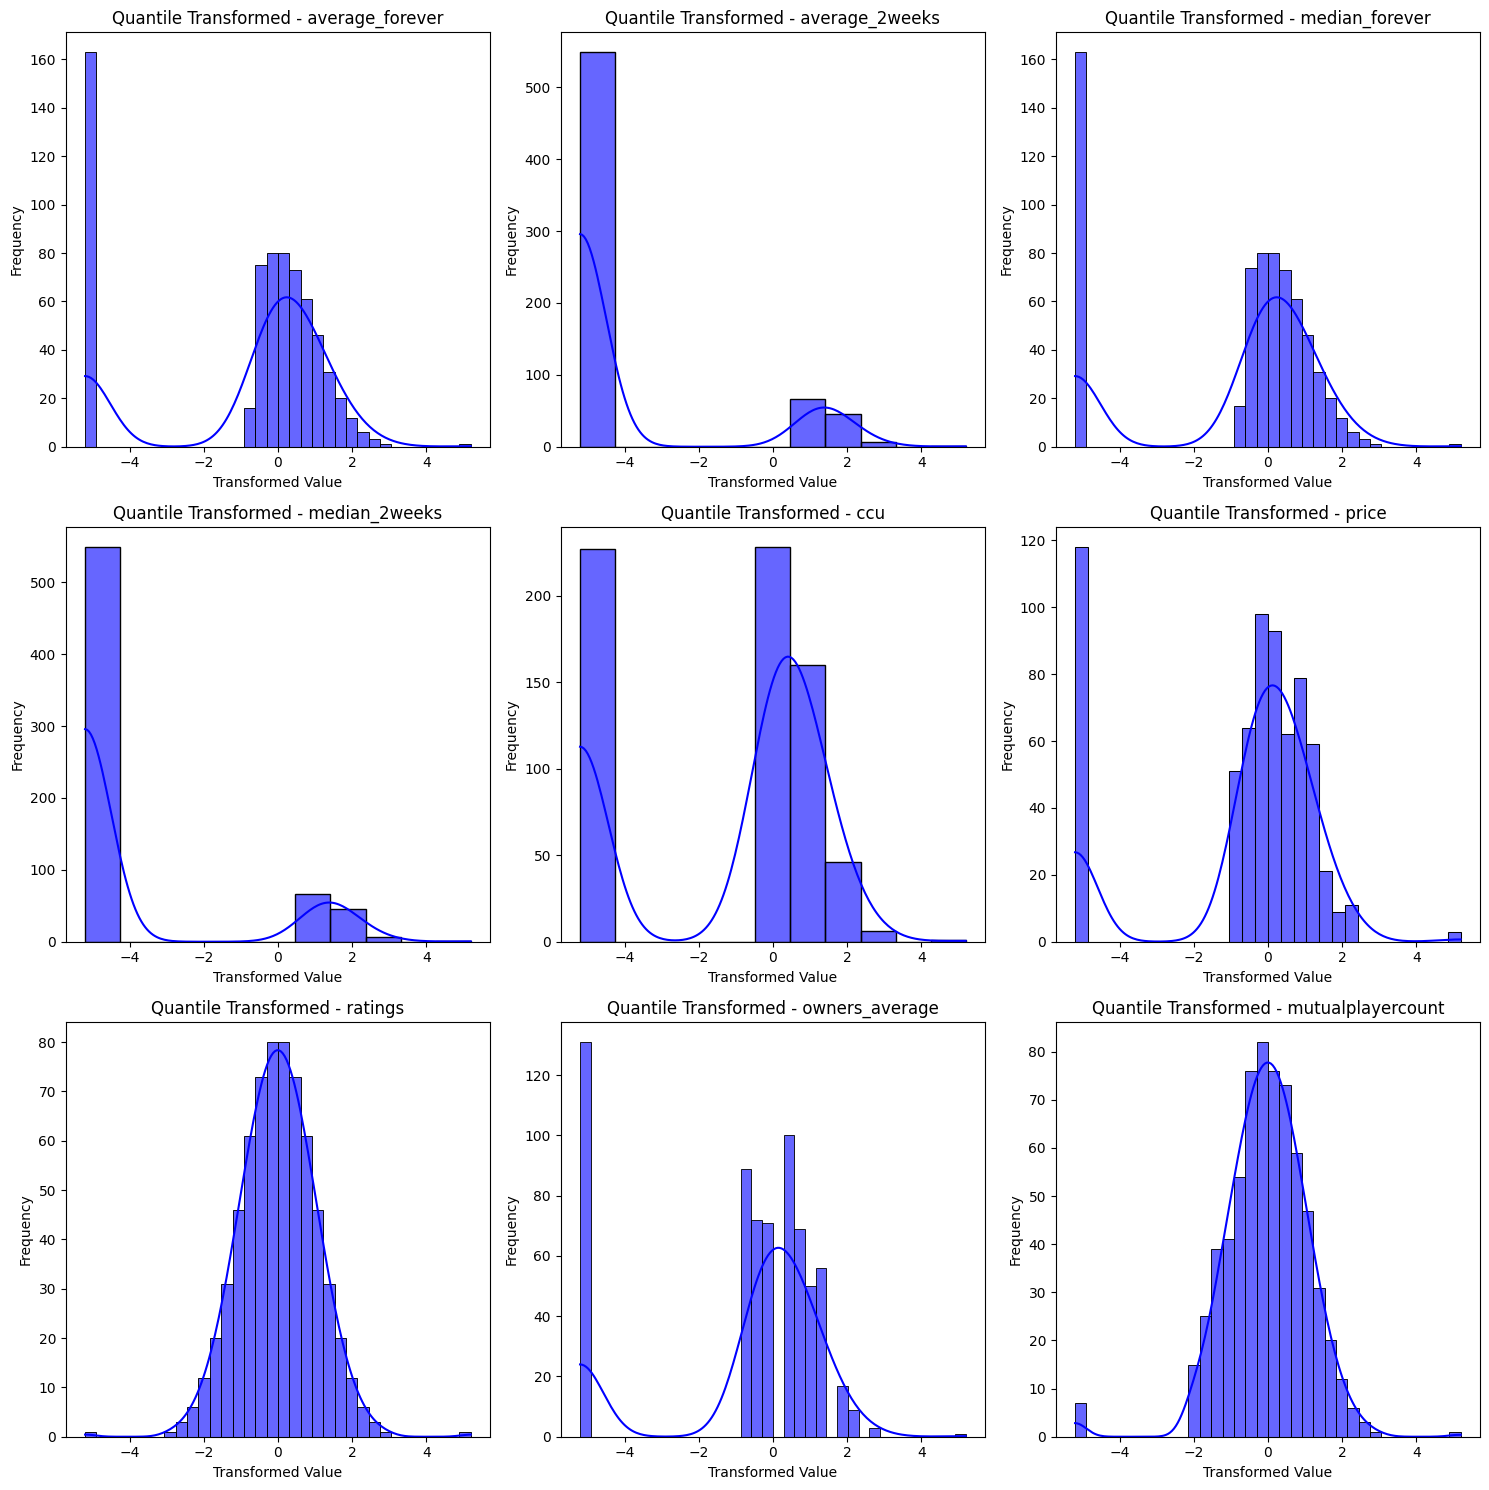

In [17]:
# Apply quantile transformation
def apply_quantile_transformation(train, validation, test):
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
    feature_cols = ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'mutualplayercount']  # Replace with actual feature column names

    train_transformed = train.copy()
    validation_transformed = validation.copy()
    test_transformed = test.copy()

    # Fit the transformer on the training data
    quantile_transformer.fit(train[feature_cols])

    # Apply the transformation to the training data
    train_transformed_cols = quantile_transformer.transform(train[feature_cols])
    validation_transformed_cols = quantile_transformer.transform(validation[feature_cols])
    test_transformed_cols = quantile_transformer.transform(test[feature_cols])

    # Add suffix to new columns and assign transformed data
    for i, col in enumerate(feature_cols):
        train_transformed[col + '_qt_normal'] = train_transformed_cols[:, i]
        validation_transformed[col + '_qt_normal'] = validation_transformed_cols[:, i]
        test_transformed[col + '_qt_normal'] = test_transformed_cols[:, i]

    return train_transformed, validation_transformed, test_transformed

# Apply quantile transformation
train_transformed, validation_transformed, test_transformed = apply_quantile_transformation(train_data, validation_data, test_data)

# Combine transformed data back into df_model
df_model_transformed = pd.concat([train_transformed, validation_transformed, test_transformed], ignore_index=True)

# Check for transformed columns
for col in ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'mutualplayercount']:
    transformed_col = col + '_qt_normal'
    if transformed_col not in train_transformed.columns:
        print(f"Column {transformed_col} is missing from the transformed DataFrame")

# Plot density histograms for the transformed data
def plot_transformed_density_histograms(data, feature_cols):
    # Prepare a subplot layout
    num_columns = 3
    num_rows = (len(feature_cols) + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    # Loop through the list of columns and plot the transformed data
    for i, col in enumerate(feature_cols):
        transformed_col = col + '_qt_normal'

        # Check if the column exists in the DataFrame
        if transformed_col not in data.columns:
            print(f"Column {transformed_col} does not exist in the DataFrame")
            continue

        # Plot the transformed data
        sns.histplot(data[transformed_col], kde=True, color='blue', alpha=0.6, ax=axes[i])
        axes[i].set_title(f'Quantile Transformed - {col}')
        axes[i].set_xlabel('Transformed Value')
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # If there are any leftover axes, turn them off
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Show the plot
    plt.show()

# Plot density histograms for the transformed training data
feature_cols = ['average_forever', 'average_2weeks', 'median_forever',
                    'median_2weeks', 'ccu', 'price', 'ratings', 'owners_average',
                    'mutualplayercount']
plot_transformed_density_histograms(train_transformed, feature_cols)


### DBSCAN

In [18]:
# Function to prepare data for DBSCAN clustering
def prepare_data_for_dbscan_clustering(df, feature_cols, validation_data, test_data):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])

    # Define ranges to test
    eps_values = np.arange(0.65, 0.95, 0.05)
    min_samples_values = range(3, 10)

    # Find the best parameters
    best_params = find_best_dbscan_params(X_scaled, eps_values, min_samples_values)

    # Apply DBSCAN clustering using the best parameters found
    eps_best, min_samples_best = best_params
    dbscan_best = DBSCAN(eps=eps_best, min_samples=min_samples_best)
    labels_best = dbscan_best.fit_predict(X_scaled)

    # Add these labels to your dataframe to analyze or visualize the clustering
    df['cluster'] = labels_best

    # Calculate silhouette scores for validation and test data
    X_val_scaled = scaler.transform(validation_data[feature_cols])
    X_test_scaled = scaler.transform(test_data[feature_cols])

    val_labels = dbscan_best.fit_predict(X_val_scaled)
    test_labels = dbscan_best.fit_predict(X_test_scaled)

    if len(set(val_labels)) > 1:
        val_score = silhouette_score(X_val_scaled, val_labels)
        print(f"Silhouette Score on Validation Data: {val_score}")
    else:
        print(f"No valid clusters formed on Validation Data.")

    if len(set(test_labels)) > 1:
        test_score = silhouette_score(X_test_scaled, test_labels)
        print(f"Silhouette Score on Test Data: {test_score}")
    else:
        print(f"No valid clusters formed on Test Data.")

    return df

# Function to find the best DBSCAN parameters
def find_best_dbscan_params(X_scaled, eps_values, min_samples_values):
    best_score = -1
    best_params = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)

            if len(set(labels)) > 1:
                score = silhouette_score(X_scaled, labels)
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                print(f"Testing eps={eps}, min_samples={min_samples}, Silhouette Score={score}")
            else:
                print(f"Testing eps={eps}, min_samples={min_samples}, No valid clusters formed.")

    print(f"Best parameters found: eps={best_params[0]}, min_samples={best_params[1]} with Silhouette Score={best_score}")
    return best_params

# Feature columns to be used for clustering
feature_cols = [col for col in train_transformed.columns if col.endswith('_qt_normal')]

# Split the combined transformed data back into train, validation, and test sets
train_transformed_combined = df_model_transformed.iloc[:train_transformed.shape[0]]
validation_transformed_combined = df_model_transformed.iloc[train_transformed.shape[0]:train_transformed.shape[0] + validation_transformed.shape[0]]
test_transformed_combined = df_model_transformed.iloc[train_transformed.shape[0] + validation_transformed.shape[0]:]

# Apply DBSCAN clustering to your data
df_model_transformed = prepare_data_for_dbscan_clustering(df_model_transformed, feature_cols, validation_transformed_combined, test_transformed_combined)


Testing eps=0.65, min_samples=3, Silhouette Score=0.32440539333063584
Testing eps=0.65, min_samples=4, Silhouette Score=0.307223965511051
Testing eps=0.65, min_samples=5, Silhouette Score=0.29669504880340064
Testing eps=0.65, min_samples=6, Silhouette Score=0.3437024829384701
Testing eps=0.65, min_samples=7, Silhouette Score=0.3360567269127592
Testing eps=0.65, min_samples=8, Silhouette Score=0.29387912000895494
Testing eps=0.65, min_samples=9, Silhouette Score=0.2490341148572039
Testing eps=0.7000000000000001, min_samples=3, Silhouette Score=0.3610981879946567
Testing eps=0.7000000000000001, min_samples=4, Silhouette Score=0.34013831727643484
Testing eps=0.7000000000000001, min_samples=5, Silhouette Score=0.32164736765557805
Testing eps=0.7000000000000001, min_samples=6, Silhouette Score=0.3195883932998396
Testing eps=0.7000000000000001, min_samples=7, Silhouette Score=0.3516403064656579
Testing eps=0.7000000000000001, min_samples=8, Silhouette Score=0.3400071533397808
Testing eps=0.7

### Similarity calculation

In [19]:
# Function to calculate similarity based on selected features
def calculate_similarity(df, features):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df[features])
    return cosine_similarity(features_scaled)

# Calculate similarity scores for later use in the recommendation system
similarity_scores = calculate_similarity(df_model_transformed, ['average_forever_qt_normal', 'ccu_qt_normal', 'ratings_qt_normal'])
print("Similarity scores calculated successfully.")

# Determine the number of unique clusters (excluding noise)
num_clusters = len(set(df_model_transformed['cluster'])) - (1 if -1 in df_model_transformed['cluster'] else 0)
print(f"Number of clusters formed (excluding noise): {num_clusters}")


Similarity scores calculated successfully.
Number of clusters formed (excluding noise): 14


###Games recommended by AFKAdvantures

In [23]:
def recommend_games_interactive(df, similarity_scores, num_recommendations=5):
    available_categories = ['single player', 'multi player', 'both']
    available_genres = ['Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Design & Illustration',
                        'Early Access', 'Education', 'Free to Play', 'Game Development', 'Gore', 'Indie',
                        'Massively Multiplayer', 'Movie', 'Nudity', 'RPG', 'Racing', 'Sexual Content',
                        'Simulation', 'Sports', 'Strategy', 'Utilities', 'Violent', 'Web Publishing']

    print("Available Categories:")
    for category in available_categories:
        print(f"- {category}")
    user_category = input("\nEnter the category you would like to play (e.g., 'single player'): ").lower().replace(' ', '_')

    print("\nAvailable Genres:")
    for genre in available_genres:
        print(f"- {genre}")
    user_genre = input("\nEnter the genre you like (e.g., 'action'): ").lower().replace(' ', '_')

    if user_category not in df.columns or user_genre not in df.columns:
        print("Invalid category or genre provided. Please check your input.")
        return None

    # Filter the DataFrame based on user input
    filtered_df = df[(df[user_genre] == 1) & (df[user_category] == 1)]
    if filtered_df.empty:
        print("No games found matching your criteria.")
        return None

    cluster_mode = filtered_df['cluster'].mode()[0]  # Most common cluster in filtered games
    cluster_filtered_df = filtered_df[filtered_df['cluster'] == cluster_mode]

    # Calculate similarity scores for filtered games within the most common cluster
    game_indices = cluster_filtered_df.index
    user_game_similarities = similarity_scores[game_indices][:, game_indices]
    similarity_sum = np.sum(user_game_similarities, axis=0)
    if np.max(similarity_sum) == 0:
        print("Similarity scores are all zero.")
        return None
    similarity_sum_normalized = similarity_sum / np.max(similarity_sum)  # Normalize the scores

    # Fetch the most similar games based on normalized scores within the cluster
    most_similar_indices = np.argsort(-similarity_sum_normalized)[:num_recommendations]
    recommendations = cluster_filtered_df.iloc[most_similar_indices]

    # Preparing the final DataFrame to return
    recommendations = recommendations[['name', 'ratings', 'price', 'cluster']]
    recommendations['scaled_similarity_score'] = similarity_sum_normalized[most_similar_indices]
    recommendations[user_genre] = 1  # Since user_genre is dynamically chosen, mark it as 1 (selected)
    recommendations[user_category] = 1  # Since user_category is dynamically chosen, mark it as 1 (selected)

    return recommendations.style.bar(subset=['scaled_similarity_score', 'ratings'], color='#fd7e14')\
                        .format({
                            'ratings': "{:.2f}",
                            'price': "${:.2f}",
                            'scaled_similarity_score': "{:.4f}"
                        })\
                        .set_properties(**{'background-color': '#343a40', 'color': '#ffffff'})\
                        .set_caption("Top Recommended Games")\
                        .set_table_styles([{'selector': 'caption',
                                            'props': [('color', 'white'),
                                                      ('font-size', '16px')]}])

# Example usage after clusters have been assigned in df_model_transformed
recommended_games = recommend_games_interactive(df_model_transformed, similarity_scores, num_recommendations=5)
if recommended_games is not None:
    print("Based on your interest, games recommended by AFKAdventures are:")
    display(recommended_games)  # Use display for Jupyter Notebook to render styled DataFrame

Available Categories:
- single player
- multi player
- both

Enter the category you would like to play (e.g., 'single player'): single player

Available Genres:
- Action
- Adventure
- Animation & Modeling
- Casual
- Design & Illustration
- Early Access
- Education
- Free to Play
- Game Development
- Gore
- Indie
- Massively Multiplayer
- Movie
- Nudity
- RPG
- Racing
- Sexual Content
- Simulation
- Sports
- Strategy
- Utilities
- Violent
- Web Publishing

Enter the genre you like (e.g., 'action'): Gore
Based on your interest, games recommended by AFKAdventures are:


,name,ratings,price,cluster,scaled_similarity_score,gore,single_player
279,"Seed Of The Arcane , Episode 1",0.78,$12.99,0,1.0000,1,1
